## NYC Bike Share Project

Using citi bike data in New York City to predict demand

### Data Visualization

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
import numpy as np
import seaborn as sns
from geodatasets import get_path

In [5]:
#read shape data of the five NYC boroughs
path_to_data = get_path('nybb')
gdf = gpd.read_file(path_to_data)
gdf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [6]:
gdf = gdf.set_index('BoroName')
gdf

,BoroCode,Shape_Leng,Shape_Area,geometry
BoroName,,,,
Staten Island,5,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
Queens,4,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
Brooklyn,3,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
Manhattan,1,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
Bronx,2,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


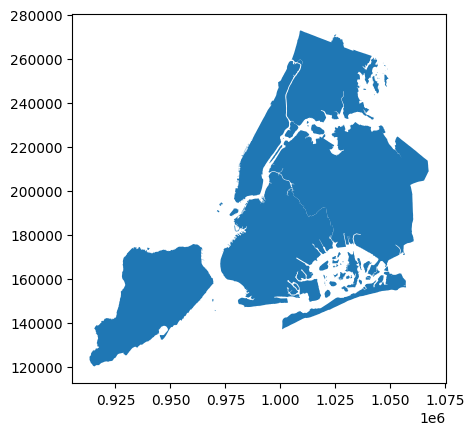

In [7]:
gdf.plot()
plt.show()

In [8]:
gdf.bounds

,minx,miny,maxx,maxy
BoroName,,,,
Staten Island,9.131751e+05,120121.881254,9.705701e+05,175708.962036
Queens,9.946086e+05,136681.776184,1.067383e+06,231157.996399
Brooklyn,9.726197e+05,146772.031799,1.030453e+06,208564.104004
Manhattan,9.710135e+05,188082.322388,1.010066e+06,259547.770386
Bronx,1.002623e+06,225426.884583,1.049167e+06,272844.293640


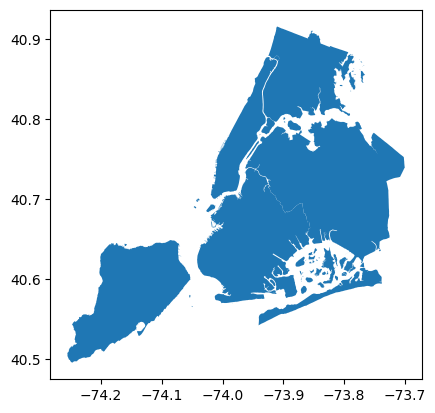

In [9]:
gdf = gdf.to_crs(4326) #change coordinate reference system to latitude and longitude
gdf.plot()
plt.show()

In [10]:
import pandas as pd

In [11]:
city_bike_data = pd.read_csv('201306-citibike-tripdata.csv')

In [12]:
city_bike_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,1
2,2059,2013-06-01 00:00:44,2013-06-01 00:35:03,406,Hicks St & Montague St,40.695128,-73.995951,406.0,Hicks St & Montague St,40.695128,-73.995951,19599,Customer,NaN,0
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,Little West St & 1 Pl,40.705693,-74.016777,310.0,State St & Smith St,40.689269,-73.989129,15567,Subscriber,1983.0,1


In [13]:
city_bike_data.count()

tripduration               577703
starttime                  577703
stoptime                   577703
start station id           577703
start station name         577703
start station latitude     577703
start station longitude    577703
end station id             559644
end station name           559644
end station latitude       559644
end station longitude      559644
bikeid                     577703
usertype                   577703
birth year                 337382
gender                     577703
dtype: int64

In [14]:
print(city_bike_data['start station latitude'].min(),city_bike_data['start station latitude'].max())

40.6466068 40.771522


In [15]:
print(city_bike_data['start station longitude'].min(),city_bike_data['start station longitude'].max())

-74.01713445 -73.9500479759


Data appears to be restricted to manhattan based off of the start and stop latitudes and longitudes.

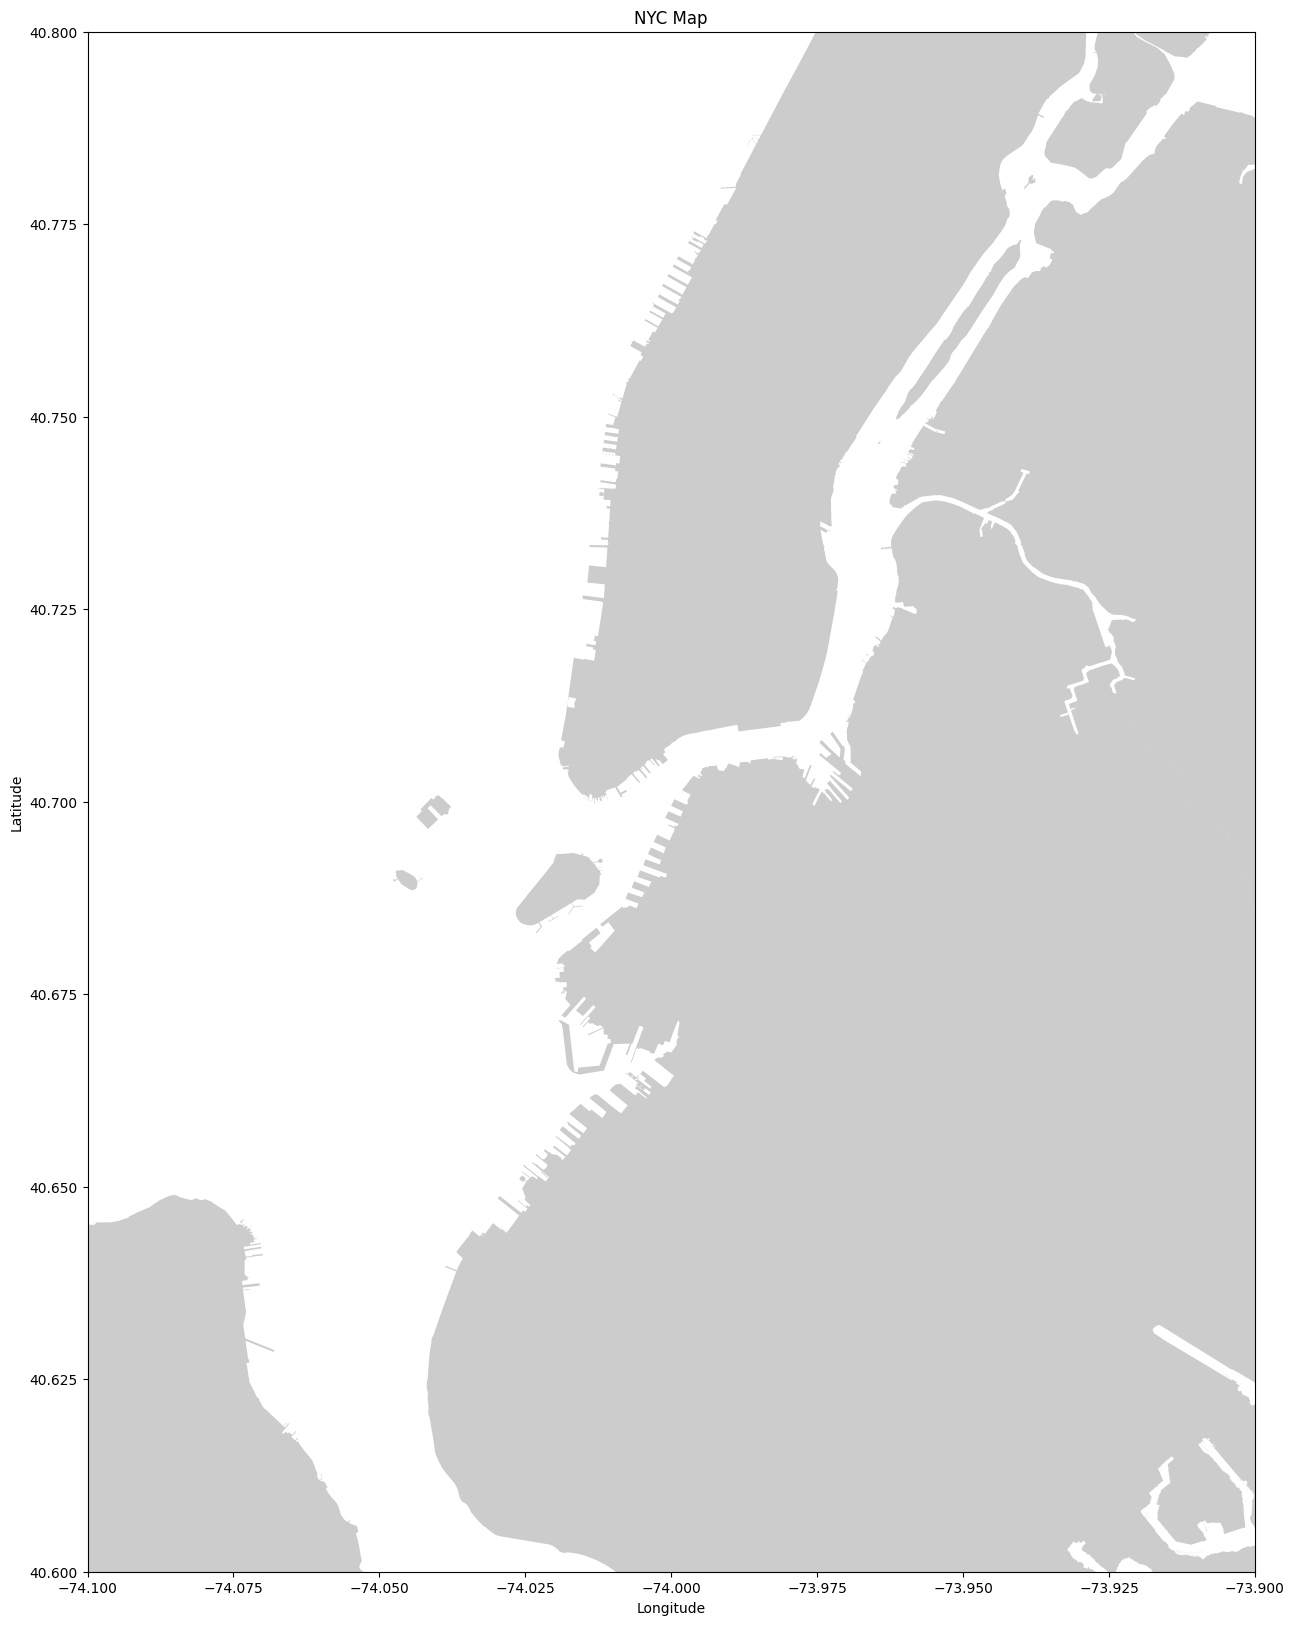

In [22]:

def plot_nyc(data: pd.DataFrame = None, lat_col: str = None, lng_col: str = None, title: str = 'NYC Map', figsize: tuple[int] = (20,20)):
    _ , ax = plt.subplots(figsize=figsize)
    gdf.plot(ax=ax, alpha=0.4, color='grey')

    if lat_col and lng_col:
        start_geometry = [Point(xy) for xy in zip(data[lng_col], data[lat_col])]
        start_gdf = gpd.GeoDataFrame(city_bike_data, geometry=start_geometry)
        start_gdf.plot(ax=ax, markersize=0.001, color='blue', marker='o')

    ax.set_xlim(-74.1,-73.9)
    ax.set_ylim(40.6,40.8)
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plot_nyc()

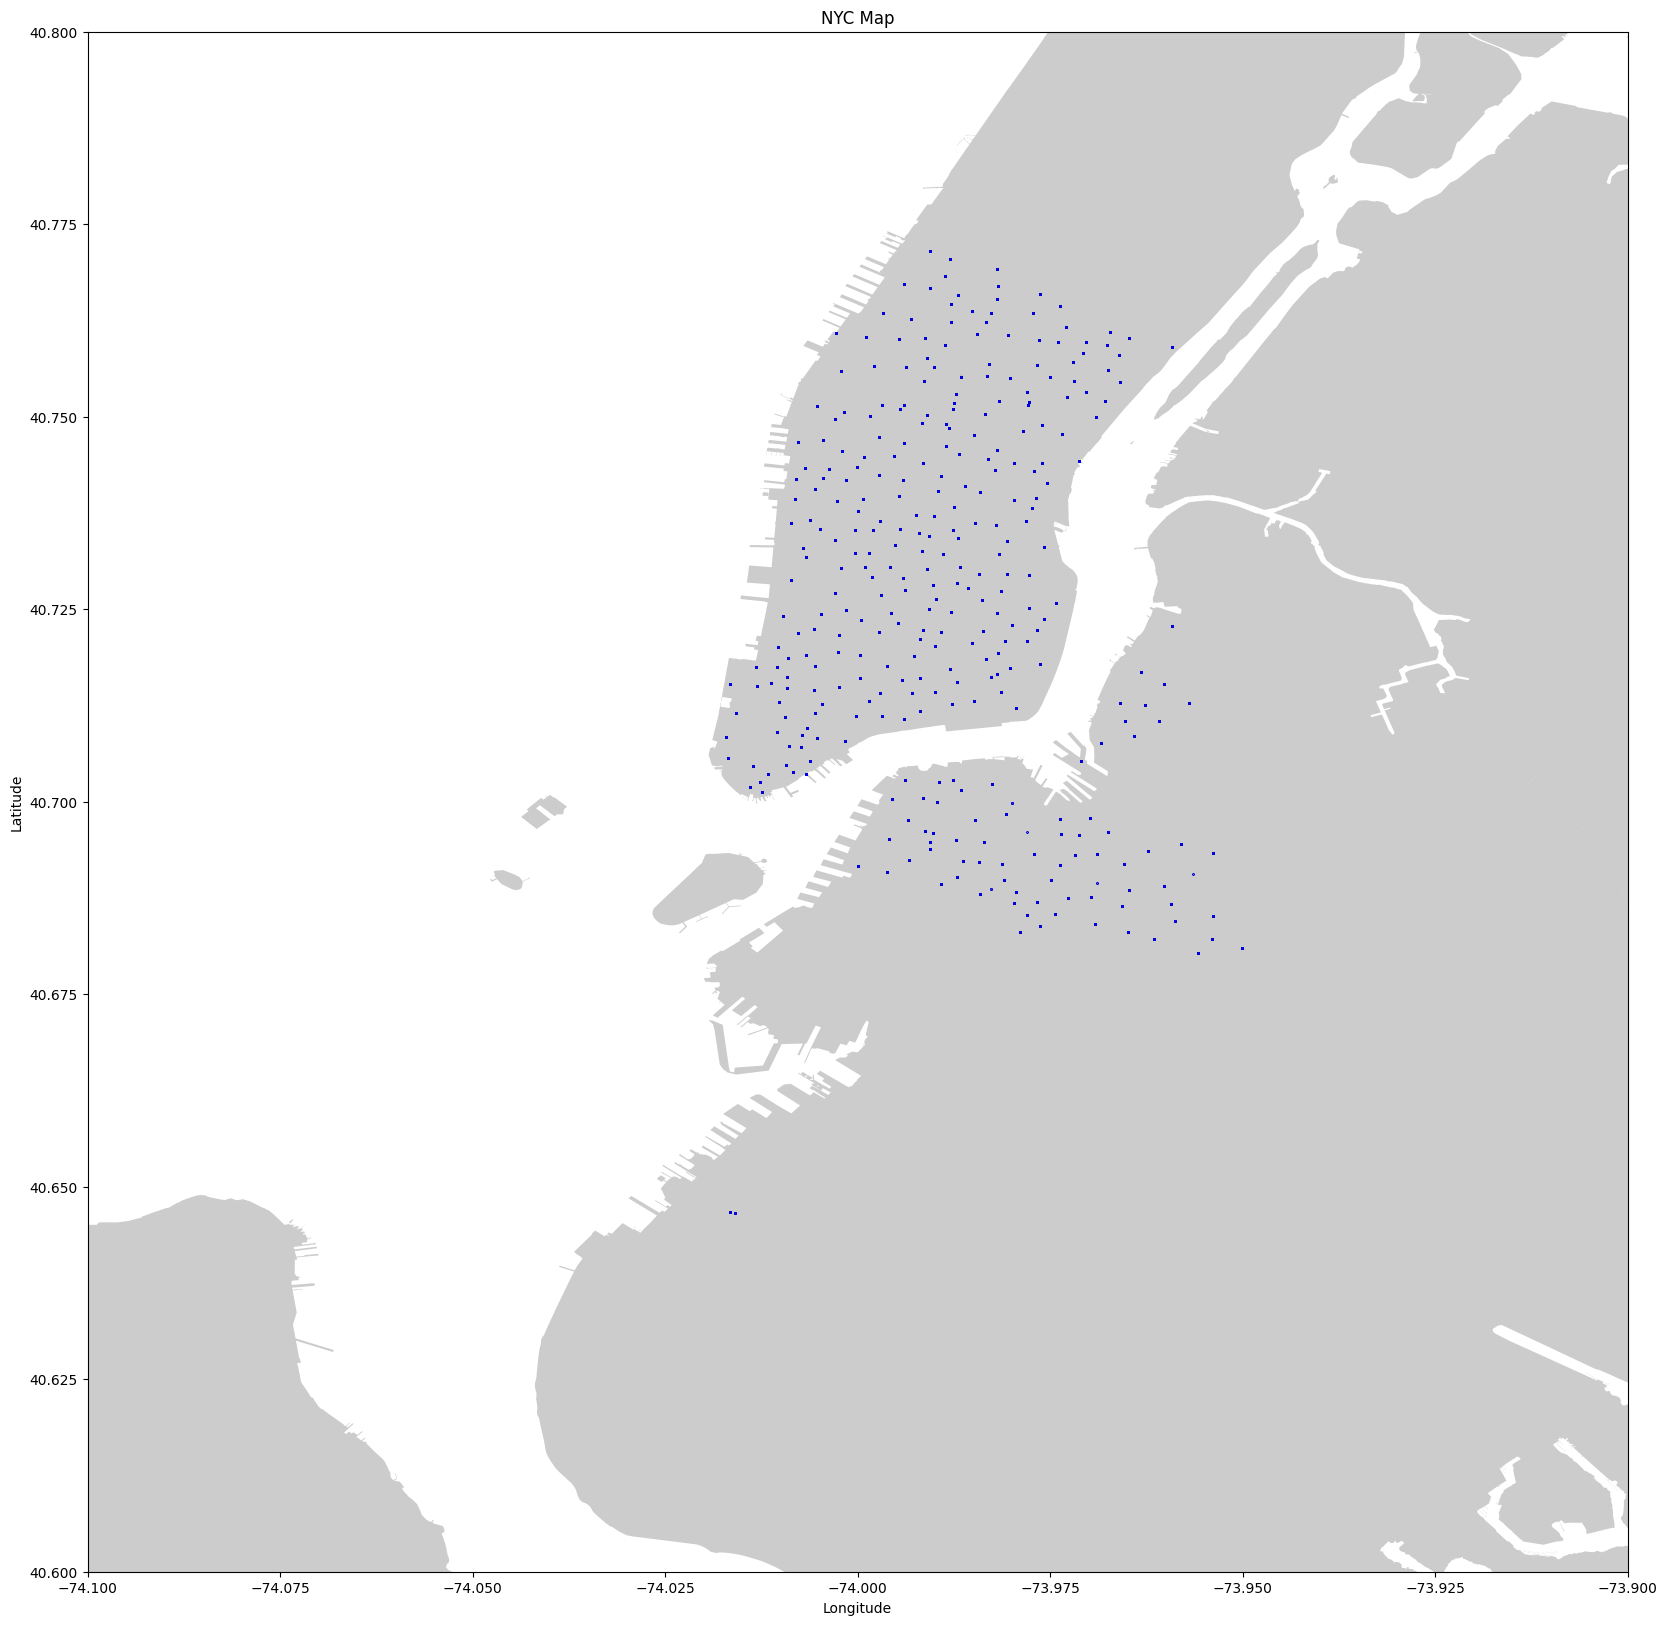

In [24]:
plot_nyc(data= city_bike_data, lat_col="end station latitude",lng_col="end station longitude")

In [37]:
poi_data = pd.read_csv("Point_Of_Interest.csv")
poi_data.head()

,the_geom,SEGMENTID,COMPLEXID,SAFTYPE,SOS,PLACEID,FACI_DOM,BIN,BOROUGH,CREATED,MODIFIED,FACILITY_T,SOURCE,B7SC,PRI_ADD,NAME
0,POINT (-74.00701717096757 40.724634757833414),31895,0,N,1.0,567,9,0,1.0,05/14/2009 12:00:00 AM,11/18/2011 12:00:00 AM,6,DoITT,19743001.0,0,HOLLAND
1,POINT (-73.82661642130311 40.797182526598505),306303,3378,N,2.0,568,8,0,4.0,05/14/2009 12:00:00 AM,01/09/2017 12:00:00 AM,6,DoITT,49731001.0,0,WHITESTONE
2,POINT (-73.99395441100663 40.70384707235758),144842,3960,N,2.0,576,8,0,3.0,05/14/2009 12:00:00 AM,01/22/2018 12:00:00 AM,6,DoITT,39734001.0,0,BROOKLYN
3,POINT (-73.9919414213091 40.70960010711745),162664,0,N,1.0,580,8,0,1.0,05/14/2009 12:00:00 AM,05/11/2011 12:00:00 AM,6,DoITT,19795001.0,0,MANHATTAN
4,POINT (-73.9526609766105 40.73906602249743),157362,0,N,1.0,582,8,0,3.0,05/14/2009 12:00:00 AM,03/03/2017 12:00:00 AM,6,DoITT,39740001.0,0,PULASKI


In [38]:
lat = [float(poi_data["the_geom"].loc[i].split()[1].strip("(")) for i in range(len(poi_data))]
long = [float(poi_data["the_geom"].loc[i].split()[2].strip(")")) for i in range(len(poi_data))]
poi_data["Latitude"] = lat
poi_data["Longitude"] = long
poi_data.drop(labels=["the_geom"])

KeyError: "['the_geom'] not found in axis"